In [ ]:
from baselines.common.atari_wrappers import FrameStack
from collections import namedtuple
import gym
import math
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [317]:
frames = 4
env = FrameStack(gym.make('Breakout-v0'), frames)
env.reset()

Let's see if (and how) the framestack by openai works...

In [66]:
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print('Framestack shape: ' + str(state._force().shape))
print('                    ^    ^    ^')
print('                    |    |    |')
print('       frame width  ͞     |    |')
print('                        |    |')
print('          frame height  ͞     |')
print('                            |')
print('   4 stacked RGB channels   ͞  ')

Framestack shape: (210, 160, 12)
                    ^    ^    ^
                    |    |    |
       frame width  ͞     |    |
                        |    |
          frame height  ͞     |
                            |
   4 stacked RGB channels   ͞  


So we have that the frames are not stacked in width/height, but they are added to the tensor in the "channel" dimension: instead of having just 3 channels (RGB) we will have 4 frames * 3 RGB channels = 12 channels.
If we group these 12 channels in groups of 3 channels \[ \[0,1,2\], \[3,4,5\], ... \] we get the frames composing the framestack.

Let's print them

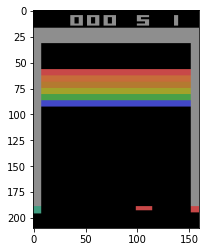

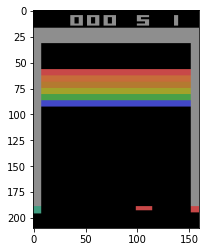

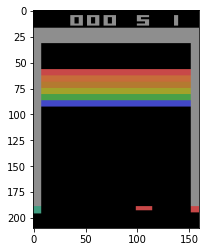

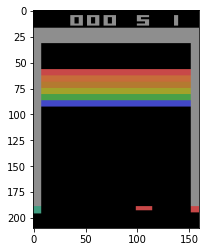

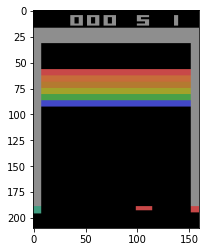

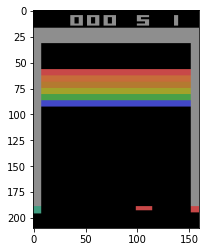

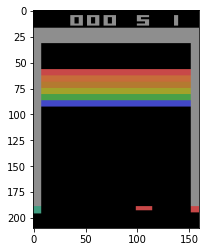

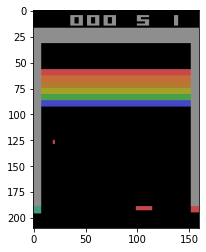

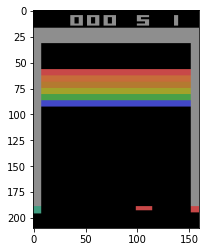

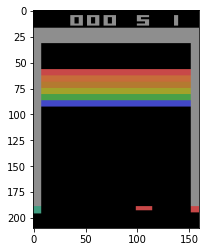

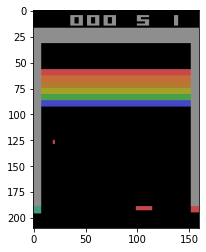

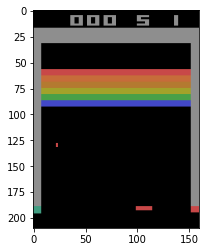

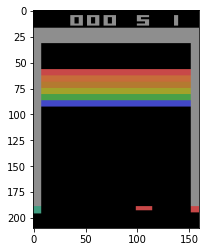

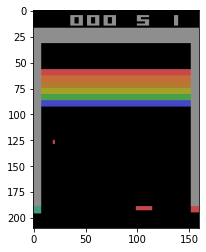

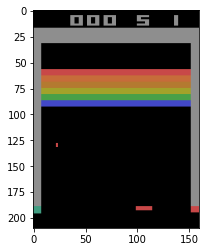

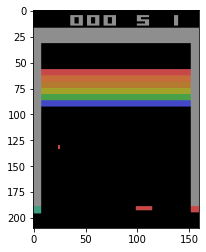

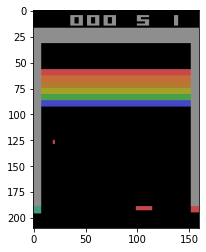

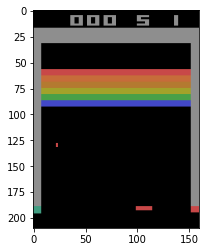

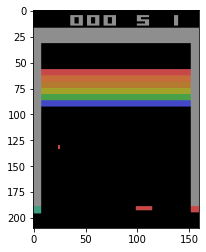

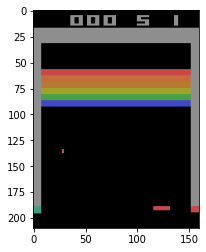

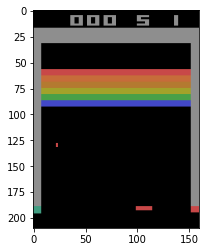

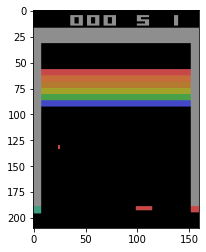

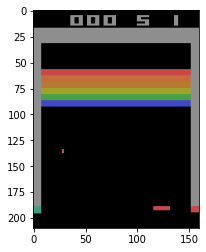

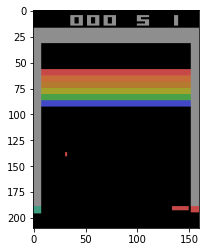

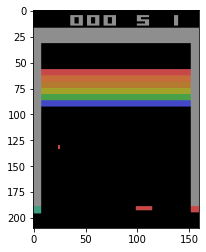

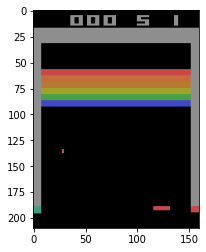

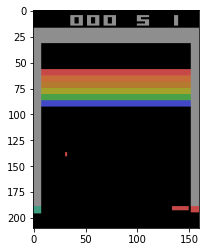

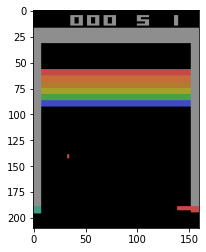

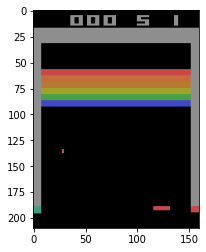

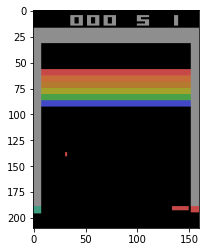

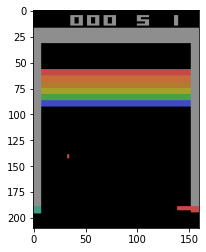

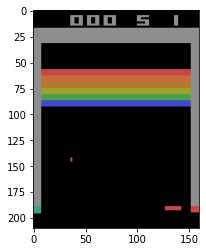

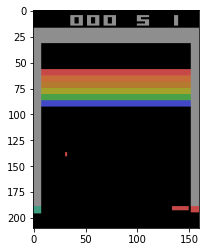

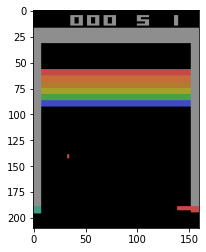

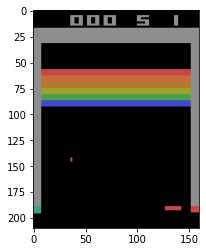

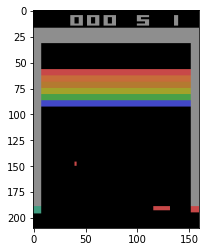

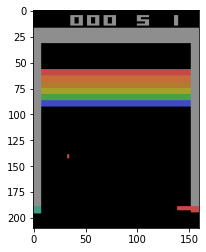

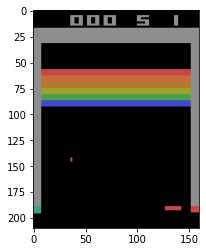

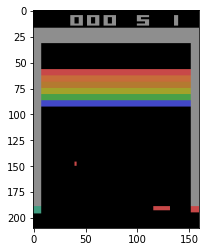

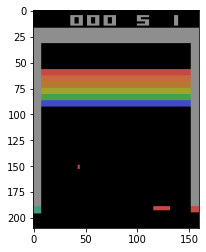

KeyboardInterrupt: 

In [318]:
env.reset()

for i in range(10):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    for i in range(frames):
        plt.imshow(state._force()[:,:,3*i:3*(i+1)])
        plt.show()
    time.sleep(1)
    

We can (kinda) see that the very first k frames are all the same...

This is because the guys at OpenAI know their stuff and extended the regular env, overriding `env.reset()` like this:
```python
 def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()
```

Long story short, the Framestack wrapper **is** a deque of frames which is updated at every step by appending the latest state and removing the oldest. On initialization, i.e. when calling `env.reset()`, the deque is initialized with the same initial state to fill the circular buffer. 

In [116]:
def random_loop():
    done = False
    try:
        while not done:
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
    finally:
        env.close()

In [319]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs, frame_stack=4):
        super(DQN, self).__init__()

        """
        Construct a new DQN object.
        
        :param h: The height of the image.
        :param w: The width of the image.
        :param outputs: The number of outputs.
        """
        self.conv1 = nn.Conv2d(3*frame_stack, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # (Size - Kernel size + 2 * Padding) // Stride --> see https://cs231n.github.io/convolutional-networks/
        def conv2d_size_out(size, kernel=5, stride=2):
            return (size - kernel) // stride + 1
        
        # Compute convolution output dimensions
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        
        # Conv output width * conv output height * conv output channels
        self.linear_input_size = convw * convh * 32
                 
        # A fully connected layer for the output
        self.head = nn.Linear(self.linear_input_size, outputs)
        
    # NN forward pass    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # TODO should we use maxpooling? or any other pooling?
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [419]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """
        Saves a transition.
        
        :param *args: transition components, i.e. state, action, reward, next_state
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples the replay buffer.
        
        :param batch_size: how many transitions are sampled.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Epsilon-greedy decay

$ \epsilon = \epsilon_{end} + (\epsilon_{start} - \epsilon_{end}) e^{-\frac{steps}{decay}}  $

In [428]:
class DQNTraining():
    
    def __init__(self, env, batch_size=128, gamma=0.999, 
                 eps_start=0.9, eps_end=0.05, eps_decay=200, 
                 update_every=10, memory_size=10000):
        """
        The training support object has two DQNs: policy and target, see 
        https://greentec.github.io/reinforcement-learning-third-en/#soft-update-target-network
        
        :param env: gym environment
        :param batch_size: how many transitions are sampled from the replay memory for training.
        :param gamma: discount.
        :param eps_start: initial exploration rate (for epsilon-greedy policy).
        :param eps_decay: controls the rate of decay (for epsilon-greedy policy).
        :param eps_end: final exploration rate (for epsilon-greedy policy).
        :param update_every: how often the target net is updated with weights from the policy network.
        :param memory_size: replay buffer size
        """
        
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.update_every = update_every
        
        # Might be useful later on
        self.n_actions = env.action_space.n
        
        # State dimensions
        self.state_h = env.observation_space.shape[0]
        self.state_w = env.observation_space.shape[1]
        
        # Policy & target nets
        self.policy_network = DQN(self.state_h, self.state_w, self.n_actions)
        self.target_network = DQN(self.state_h, self.state_w, self.n_actions)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.RMSprop(self.policy_network.parameters())
        
        # Replay memory
        self.memory = ReplayMemory(memory_size)
        
        self.total_steps = 0
        
        
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                        math.exp(-1. * self.total_steps / self.eps_decay)
        self.total_steps += 1
        
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_network(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], dtype=torch.long)
        
    # TODO da rivedere (possibile mismatch tra indici!)
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Optimization steps sample the replay buffer
        transitions = self.memory.sample(self.batch_size)
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
            
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = [s for s in batch.next_state if s is not None]
        non_final_next_states = torch.cat(non_final_next_states).view(len(non_final_next_states), 12, self.state_h, self.state_w).float()
        
        state_batch = torch.cat(batch.state).view(self.batch_size, 12, self.state_h, self.state_w).float()
        action_batch = torch.cat(batch.action)
        reward_batch = torch.tensor(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size)
        next_state_values = self.target_network(non_final_next_states).max(1)[0].detach()
        next_state_values = next_state_values[non_final_mask]
        
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        
    def training_loop(self, num_episodes, render=False):
        for episode in range(num_episodes):
            print('Episode: %d/%d' % (episode+1, num_episodes))
            # Reset env
            state = torch.tensor(env.reset())
            done = False
            while not done:
                env.render()
                # Let agent perform an action according to an eps-greedy policy
                action = self.select_action(state.view((1, 12, self.state_h, self.state_w)).float()) # TODO avoid explicit reference to frame stack
                
                # Take step
                next_state, reward, done, _ = self.env.step(action)
                
                if not done:
                    next_state = torch.tensor(next_state._force())
                else:
                    next_state = None
                
                # Remember transition
                self.memory.push(state, action, reward, next_state)

                # Convert to tensors
                reward = torch.tensor([reward]) # Is this needed?

                # Run optimization step
                self.optimize_model()

                # Update state 
                if not done:
                    state = torch.tensor(next_state)
                
            if episode % self.update_every == 0:
                self.target_network.load_state_dict(self.policy_network.state_dict())
                


Replay memory for experience replay.<br>
The Transition "type" is used to represent one SARS' (state, action, reward, next state) sequence.

In [429]:
agent = DQNTraining(env)
agent.training_loop(100, render=True)

Episode: 1/100


/home/alessandro/projects/uni/autonomous/.venv/lib64/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: The shape of the mask [128] at index 0 does not match the shape of the indexed tensor [127] at index 0